# Funnel Analysis Data Challenge

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import collections

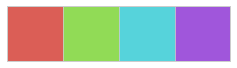

In [2]:
sns.palplot(sns.color_palette("hls", 4))
colors = sns.color_palette("hls", 4)

## Problem Description
You are looking at data from an e-commerce website. The site is very simple and has just 4
pages:
* The first page is the home page. When you come to the site for the first time, you can
only land on the home page as a first page.
* From the home page, the user can perform a search and land on the search page.
* From the search page, if the user clicks on a product, she will get to the payment page,
where she is asked to provide payment information in order to buy that product.
* If she does decide to buy, she ends up on the confirmation page

The company CEO isn't very happy with the volume sales and, especially, of sales coming
from new users. Therefore, she asked you to investigate whether there is something wrong in
the conversion funnel or, in general, if you could suggest how conversion rate can be improved.

Specifically, she is interested in :
* A full picture of funnel conversion rate for both desktop and mobile
* Some insights on what the product team should focus on in order to improve conversion rate as well as anything you might discover that could help improve conversion rate.

### user_table
* `user_id` : the ID of the user. It is unique by user and can be joined to user id in all other tables
* `date` : the date when the user firstly landed on the site
* `device` : user device. Can be mobile or desktop
* `sex` : male/female

### other tables
* `user_id` : the ID of the user. It is unique by user and can be joined to user id in all other tables
* `page` : always the page wrt the relevant table (`payment_confirmation_table` -> `payment_confirmation_page`)

## Load Data

In [3]:
# load data
users = pd.read_csv('Funnel/user_table.csv', index_col=0)
home_page = pd.read_csv('Funnel/home_page_table.csv', index_col=0)
search_page = pd.read_csv('Funnel/search_page_table.csv', index_col=0)
payment_page = pd.read_csv('Funnel/payment_page_table.csv', index_col=0)
payment_confirmation_page = pd.read_csv('Funnel/payment_confirmation_table.csv', index_col=0)

# set date of users to datetime format
users['date'] = users['date'].apply(lambda x: pd.to_datetime(x))

# merge tables by user_id. If user does not appear in a particular table, value = 0 for that table's column
funnel = pd.DataFrame(users)

tables = [home_page, search_page, payment_page, payment_confirmation_page]
cols = ['Home','Search','Payment','PayConfirm']
colors = {col : sns.color_palette("hls", 4)[i] for i, col in enumerate(cols)}

for i, table in enumerate(tables):
    funnel = pd.concat([funnel, table], axis=1)
    funnel.rename(columns={'page' : cols[i]}, inplace=True)
    
funnel.fillna(0, inplace=True)
funnel[cols] = funnel[cols].applymap(lambda x: 1 if x != 0 else 0)

## Totals

In [4]:
# Sum table columns by device, sex
conversion_nums = funnel.groupby(['device','sex']).sum()
conversion_totals = funnel.groupby(['device']).sum()
conversion_nums

Home  Search  Payment  PayConfirm
device  sex                                       
Desktop Female  29997   15091     1530          74
        Male    30203   15009     1480          76
Mobile  Female  15078    7585     1570         167
        Male    15122    7515     1450         135

Calculate conversion rates between steps. Conversion rate is the rate between each step. 
* C1 = Home Page -> Search Page
* C2 = Search Page -> Payment Page
* C3 = Payment Page -> Payment Processing Page

In [5]:
conversion_rates = pd.DataFrame(index=conversion_nums.index, columns=['C1','C2','C3'])
# conversion function for applying to df
f = lambda x, y: y/x if x != 0 else 0

conversion_rates['C1'] = conversion_nums[['Home','Search']].apply(lambda x: f(*x), axis=1)
conversion_rates['C2'] = conversion_nums[['Search','Payment']].apply(lambda x: f(*x), axis=1)
conversion_rates['C3'] = conversion_nums[['Payment','PayConfirm']].apply(lambda x: f(*x), axis=1)

conversion_rates

C1        C2        C3
device  sex                                 
Desktop Female  0.503084  0.101385  0.048366
        Male    0.496937  0.098608  0.051351
Mobile  Female  0.503051  0.206987  0.106369
        Male    0.496958  0.192947  0.093103

## By Date

In [6]:
daily = funnel.groupby('date').sum()
device_grouped = funnel.groupby(['device','date']).sum()
sex_grouped = funnel.groupby(['sex','date']).sum()
all_grouped = funnel.groupby(['device','sex','date']).sum()

def rate_calc(data, cols):
    
    df = pd.DataFrame(index=data.index)
    
    for i, item in enumerate(cols):
        rate = item
        if i == 0:
            df[rate] = data[rate]
        else:
            df[rate] = data[[cols[i-1], cols[i]]].apply(lambda x: f(*x), axis=1)

    rate = 'Complete'
    df[rate] = data[cols[-1]]/data[cols[0]]
            
    return df

daily_rates = rate_calc(daily, cols)
device_rates = rate_calc(device_grouped, cols)
sex_rates = rate_calc(sex_grouped, cols)
all_rates = rate_calc(all_grouped, cols)

daily_rates.head()

,Home,Search,Payment,PayConfirm,Complete
date,,,,,
2015-01-01,712,0.612360,0.174312,0.078947,0.008427
2015-01-02,721,0.619972,0.187919,0.059524,0.006935
2015-01-03,760,0.555263,0.151659,0.109375,0.009211
2015-01-04,713,0.626928,0.170022,0.092105,0.009818
2015-01-05,754,0.612732,0.190476,0.125000,0.014589


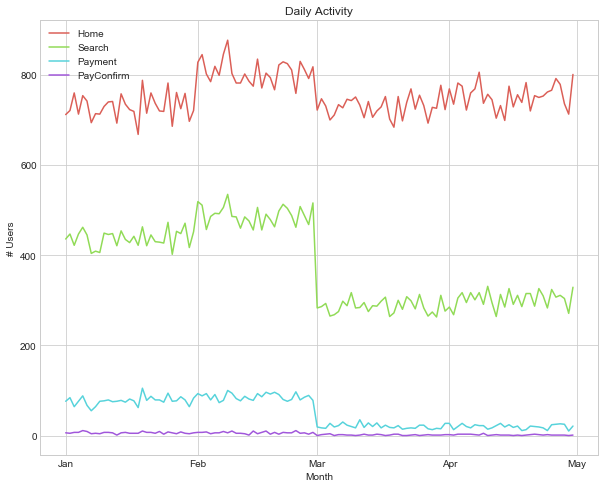

In [7]:
fig, ax = plt.subplots(figsize=(10,8))
for col in cols:
    ax.plot(daily.index, daily[col], c=colors[col])

# format ticks
import matplotlib.dates as mdates

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
monthFmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(monthFmt)

ax.xaxis.grid(True)

plt.title('Daily Activity')
plt.ylabel('# Users')
plt.xlabel('Month')
plt.legend()

The daily activity for all devices and genders is shown above. Something clearly happens between Feb and March that contributes to a sharp drop off in conversion rates to the Search Page and Payment Page. Since this plot only shows #s, not rate, it is not clear if it happens for one page or the other. Let's plot conversion rates.

### Conversion rates
The conversion rate for each page refers to what percent of people from the previous page arrived at the current page. For `Home`, it equals the number of users total, since that is the starting point. Below is a facet grid showing conversion rates over time separated by device (Mobile or Desktop) and sex (Male or Female).

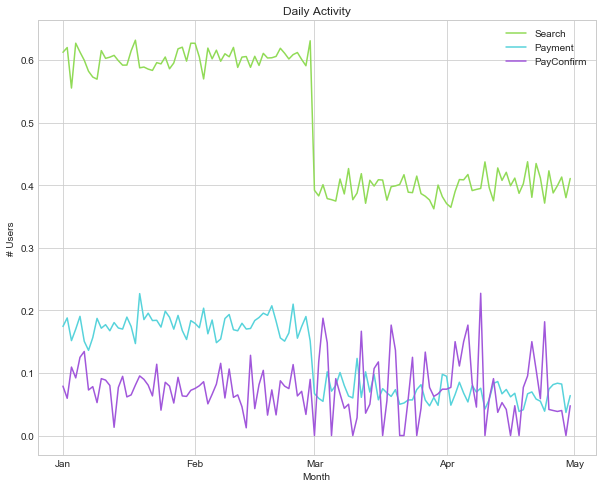

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
for col in cols[1:]:
    ax.plot(daily_rates.index, daily_rates[col], c=colors[col])
    
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
monthFmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(monthFmt)

ax.xaxis.grid(True)

plt.title('Daily Activity')
plt.ylabel('# Users')
plt.xlabel('Month')
plt.legend()

It looks like the conversion problem happens both for Search and Payment pages, but not Page Confirm. This likely isn't a "gender" thing, so lets check device type to see if it's a device thing or an over all site problem.

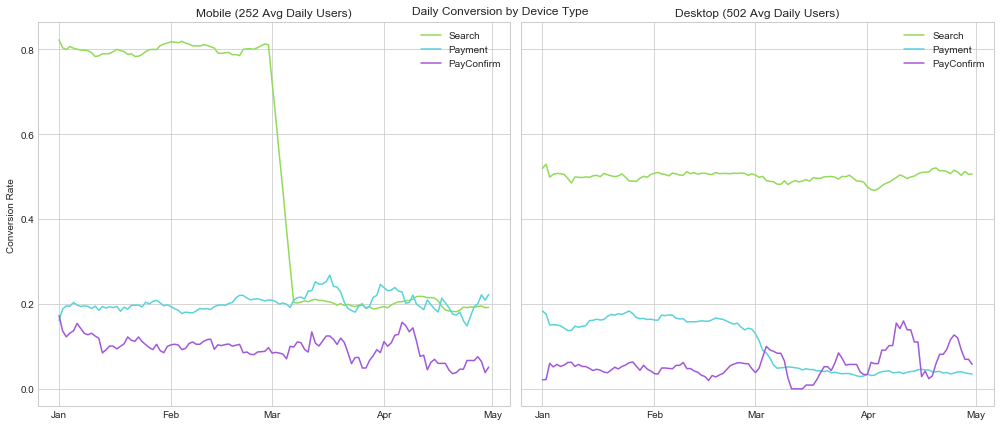

In [22]:
mobile = device_rates.loc['Mobile']
mobile_m = mobile.rolling('7d').mean()
desktop = device_rates.loc['Desktop']
desktop_m = desktop.rolling('7d').mean()

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)
for col in cols[1:]:
#    axes[0].plot(mobile.index, mobile[col], '.', c=colors[col])
    axes[0].plot(mobile_m.index, mobile_m[col], c=colors[col])
#    axes[1].plot(desktop.index, desktop[col], '.', c=colors[col])
    axes[1].plot(desktop_m.index, desktop_m[col], c=colors[col])

    
for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    monthFmt = mdates.DateFormatter('%b')
    ax.xaxis.set_major_formatter(monthFmt)

    ax.xaxis.grid(True)
    
    ax.legend()
    
axes[0].set_title('Mobile ({:.0f} Avg Daily Users)'.format(mobile['Home'].mean()))
axes[1].set_title('Desktop ({:.0f} Avg Daily Users)'.format(desktop['Home'].mean()))

axes[0].set_ylabel('Conversion Rate')

fig.suptitle('Daily Conversion by Device Type')
fig.tight_layout()

It looks like there is a serious problem with the Mobile site in converting to the Search Page. "Zooming in" on the dates shows there is a severe dropoff in Search conversion on March 1st. 

Recommendation: There was possibly a website change then that removed some functionality of the website.

Text(0,0.5,'Conversion Rate')

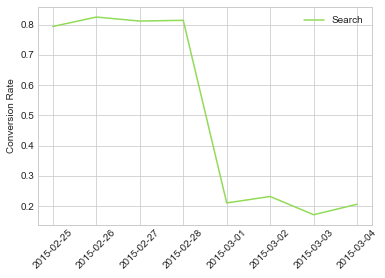

In [23]:
plt.plot(mobile.loc['2015-02-25':'2015-03-04'].index, mobile.loc['2015-02-25':'2015-03-04']['Search'], c=colors['Search'])
plt.xticks(rotation=45)
plt.legend()
plt.ylabel('Conversion Rate')